In [82]:
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
library(ggrepel)
options(warn=-1)
source("../../../../src/tools.R")
source("../../../script_figures/tools.R")
library(DT)
library(mstate)
library(dplyr)
library(miceadds)

library("colorspace")
statecols <- heat_hcl(6, c = c(80, 30), l = c(30, 90),power = c(1/5, 2))[c(6,5,4,3,2,1)]
ord <- c(1,2,3,4,5,6)

In [83]:
df_nejm <- read.table("df_nejm_personnalization.tsv")
df_nejm$patient_id <- rownames(df_nejm)

df_cardiff <- read.table("df_cardiff_personnalization.tsv")
df_cardiff$patient_id <- rownames(df_cardiff)

all_gen <- colnames(df_cardiff)[c(18:101)]
all_cyto <- colnames(df_cardiff)[c(102:171)]

In [84]:
# Deal with Patients that experienced relapse and death at the same time ( we add 1 day between the 2 events)
df_nejm[,c("CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without")] <- round(df_nejm[,c("CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without")],5)

df_nejm[df_nejm$Relapse_stat==1 & df_nejm$Death_in_Relapse_stat==1 & df_nejm$Relapse==df_nejm$Death_in_Relapse ,"Death_in_Relapse"] <- df_nejm[df_nejm$Relapse_stat==1 & df_nejm$Death_in_Relapse_stat==1 &
                                                                                                                                               df_nejm$Relapse==df_nejm$Death_in_Relapse & df_nejm$Relapse==df_nejm$Death_in_Relapse,"Death_in_Relapse"] + 1/365


In [85]:
## Handle some clinical variables : perf status , secondary and ahd

df_nejm$perf_status <- median(df_cardiff$perf_status)
df_nejm$secondary <- median(df_cardiff$secondary)
df_nejm$ahd <- median(df_cardiff$ahd)

In [86]:
comp <- c(colnames(df_cardiff)[startsWith(colnames(df_cardiff),"full_component_")],"overlap")
clin <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt")
demo <- c("gender","age")

cols_to_keep <- c("patient_id","CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without",
                  "CR_stat","Relapse_stat","Death_in_CR_stat",
                  "Death_in_Relapse_stat","Death_without_stat",
               c("ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"))

In [87]:
# Combine Dataframes

data <- rbind(df_nejm[,cols_to_keep],df_cardiff[,cols_to_keep])
# data[,c("ahd","perf_status","secondary")] <- lapply(data[,c("ahd","perf_status","secondary")], factor)


In [88]:
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive with Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))

In [89]:
msdata <- msprep(data = data, trans = tmat_data, 
                 time = c(NA, "CR", "Relapse","Death_in_CR","Death_in_Relapse","Death_without"), 
                 status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),
                 keep=c("patient_id","ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"))

In [90]:
# Age as time dependent covariate
msdata$age <- msdata$age + msdata$Tstart

In [91]:
events(msdata)

$Frequencies
                    to
from                 Alive Alive in CR Alive with Relapse Death in CR
  Alive                  0        2440                  0           0
  Alive in CR            0           0               1364         182
  Alive with Relapse     0           0                  0           0
  Death in CR            0           0                  0           0
  Death in Relapse       0           0                  0           0
  Death without CR       0           0                  0           0
                    to
from                 Death in Relapse Death without CR no event total entering
  Alive                             0              786       60           3286
  Alive in CR                       0                0      894           2440
  Alive with Relapse             1081                0      283           1364
  Death in CR                       0                0      182            182
  Death in Relapse                  0                0  

In [92]:
msdata <- expand.covs(msdata, covs = c("ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
expanded_itd <- colnames(msdata)[40:44]
expanded_component <- colnames(msdata)[45:129]
expanded_clin <- colnames(msdata)[130:164]
expanded_demo <- colnames(msdata)[165:174]
expanded_proposal <- colnames(msdata)[175:189]

In [103]:
covariates <- c(demo,clin,comp,"ITD","NEW_favorable","NEW_adverse","NEW_intermediate")
form <- "Surv(Tstart, Tstop, status) ~ "
for (co in c(covariates)){
    
    for (sub in c(".1",".2",".3",".4",".5")){
        form <- paste (form,paste(co,sub,sep=""),sep = " + ")
    }
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")

In [104]:
summary(cfull)$concordance

C       se(C) 
0.660552784 0.004146562

In [105]:
# library(glmnet)
# try <- msdata[msdata$time>0,]
# cvfit <- cv.glmnet(as.matrix(try[,c(expanded_demo,expanded_clin,expanded_component,expanded_itd,expanded_proposal)]), Surv(try$time,  try$status), family="cox", maxit = 1000)

In [106]:
datatable(summary(cfull)$coefficients,options= list(pageLength= 10))

HTML widgets cannot be represented in plain text (need html)

In [107]:
### Get Covariates median from msdata
covariates_median <- sapply(msdata[,c(clin,demo)], FUN=median,)
t(covariates_median)

ahd,perf_status,bm_blasts,secondary,wbc,hb,plt,gender,age
1,0,68,1,16.5,9.299995,57,1,54.05546


# III) Tutorial for  personalized outcome

# User specification 

# Empty Dataframe with Covariates : Gen, Cyto , Clin , Demo

In [131]:
user_data <- data.frame(covariates = c(demo,clin,all_gen,all_cyto))
user_data$value <- "Not specified"
rownames(user_data) <- user_data$covariates
user_data$covariates <- NULL
datatable(user_data,options= list(pageLength = 10))

HTML widgets cannot be represented in plain text (need html)

# User specifies 
covariates 

In [132]:
change_covariates <- list(t_8_13=1,del_18=1,ITD=1,age=69,wbc=17.1,SRSF2=1,STAG2=1,ASXL3=1,CNTN5=1,TP53=1)

In [133]:
user_data[names(change_covariates),"value"] <- as.vector(unlist(change_covariates))
datatable(user_data,options= list(pageLength= 10))

HTML widgets cannot be represented in plain text (need html)

# Handle Not Specified Values 

In [134]:
user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(all_gen,all_cyto) ,"value"] <- 0
user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(clin,demo) ,"value"] <- covariates_median[rownames(user_data)[user_data$value=="Not specified"]]

user_data$value <- as.numeric(user_data$value)  ### make sure values are numeric!

datatable(user_data,options= list(pageLength= 10))



HTML widgets cannot be represented in plain text (need html)

# Data Reduction with the Components 

In [135]:
# A function for Component and Proposal Classification 

In [136]:
classify_components <- function(user_data,keep=c(demo,clin,comp,"ITD"),proposal=T){
    factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
    
    user_data["full_component_t_15_17","value"] <- ifelse(user_data["t_15_17","value"]==1,1,0)
    
    user_data["full_component_inv_16","value"] <- ifelse(user_data["inv_16","value"]==1,1,0)
    
    user_data["full_component_t_8_21","value"] <- ifelse(user_data["t_8_21","value"]==1,1,0) 
    
    user_data["full_component_t_11","value"] <- ifelse((user_data["t_v_11","value"]==1 | user_data["t_9_11","value"]==1),1,0)   
    
    user_data["full_component_t_6_9","value"] <- ifelse(user_data["t_6_9","value"]==1,1,0) 
    
    user_data["full_component_inv_3","value"] <- ifelse(user_data["inv_3","value"]==1,1,0)
    
    user_data["full_component_additions","value"] <- ifelse((user_data["add_8","value"]==1 | user_data["add_11","value"]==1 |
                                                             user_data["add_13","value"]==1 | user_data["add_21","value"]==1 |
                                                             user_data["add_22","value"]==1),1,0)
    
    user_data["full_component_TP53_complex","value"] <- ifelse((user_data["TP53","value"]==1 | user_data["complex","value"]==1) ,1,0)
    
    user_data["full_component_NPM1","value"] <- ifelse(user_data["NPM1","value"]==1,1,0) 
    
    user_data["full_component_CEBPA_bi","value"] <- ifelse(user_data["CEBPA_bi","value"]==1,1,0) 
    
    user_data["full_component_DNMT3A_IDH1_2","value"] <- ifelse((user_data["DNMT3A==1","value"] & (user_data["IDH1","value"]==1 | user_data["IDH2_p.R140","value"]==1 | user_data["IDH2_p.R172","value"]==1)),1,0)
    
    user_data["full_component_WT1","value"] <- ifelse(user_data["WT1","value"]==1,1,0) 
    
    user_data["full_component_chr_splicing_multiple","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)>1 ,1,0)
    
    user_data["full_component_chr_splicing_1","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)==1,1,0)
    
    user_data["overlap","value"] <- ifelse(sum(user_data[comp,"value"],na.rm=T) >1 ,1,0)
    
    user_data["full_component_not_assigned","value"] <- ifelse((sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)>0 & sum(user_data[comp,"value"],na.rm=T)==0),1,0)
    
    user_data["full_component_no_events","value"] <- ifelse(sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)==0 ,1,0)    
    
    if (proposal==T){
        
        user_data[c("NEW_favorable","NEW_intermediate","NEW_adverse"),"value"] <- 0
        
        
        user_data["NEW_favorable","value"] <- ifelse((sum(user_data[c("full_component_NPM1","full_component_no_events","full_component_inv_16","full_component_t_8_21","full_component_t_15_17"),"value"],na.rm=T)>=1 |
                                                      (user_data["full_component_additions","value"]==1 & user_data["overlap","value"]==0)),1,0)
        
        user_data["NEW_intermediate","value"] <- ifelse(((user_data["full_component_chr_splicing_1","value"]==1 | user_data["full_component_not_assigned","value"]==1) &  user_data["NEW_favorable","value"]==0) ,1,0 )

        user_data["NEW_adverse","value"] <- ifelse(((user_data["full_component_additions","value"]==1 | user_data["full_component_TP53_complex","value"]==1 |
                                                    user_data["full_component_chr_splicing_multiple","value"]==1 | user_data["full_component_inv_3","value"]==1) &
                                                    (user_data["NEW_favorable","value"]==0 & user_data["NEW_intermediate","value"]==0)) ,1,0)
        
        user_data["NEW_favorable","value"] <- ifelse(user_data["full_component_CEBPA_bi","value"]==1 & user_data["NEW_intermediate","value"]==0 & user_data["NEW_adverse","value"]==0,1,user_data["NEW_favorable","value"])
     
        user_data["NEW_intermediate","value"] <- ifelse(((user_data["full_component_t_11","value"]==1 | user_data["full_component_t_6_9","value"]==1 |
                                                         user_data["full_component_WT1","value"]==1 | user_data["full_component_DNMT3A_IDH1_2","value"]==1) &
                                                         (user_data["NEW_favorable","value"]==0 & user_data["NEW_adverse","value"]==0)),1,user_data["NEW_intermediate","value"])

        #order is important! adverse . then intermediate otherwise we . overlap
        
        user_data["NEW_adverse","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,1,0 )
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_intermediate","value"])
        
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,1,0 )
        user_data["NEW_favorable","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_favorable","value"])

        return(user_data[c(keep,"NEW_favorable","NEW_intermediate","NEW_adverse"),,drop=F])
        
    }else{
        return(user_data[keep,,drop=F])
        }

}

# Plots

# 1) Main Plots

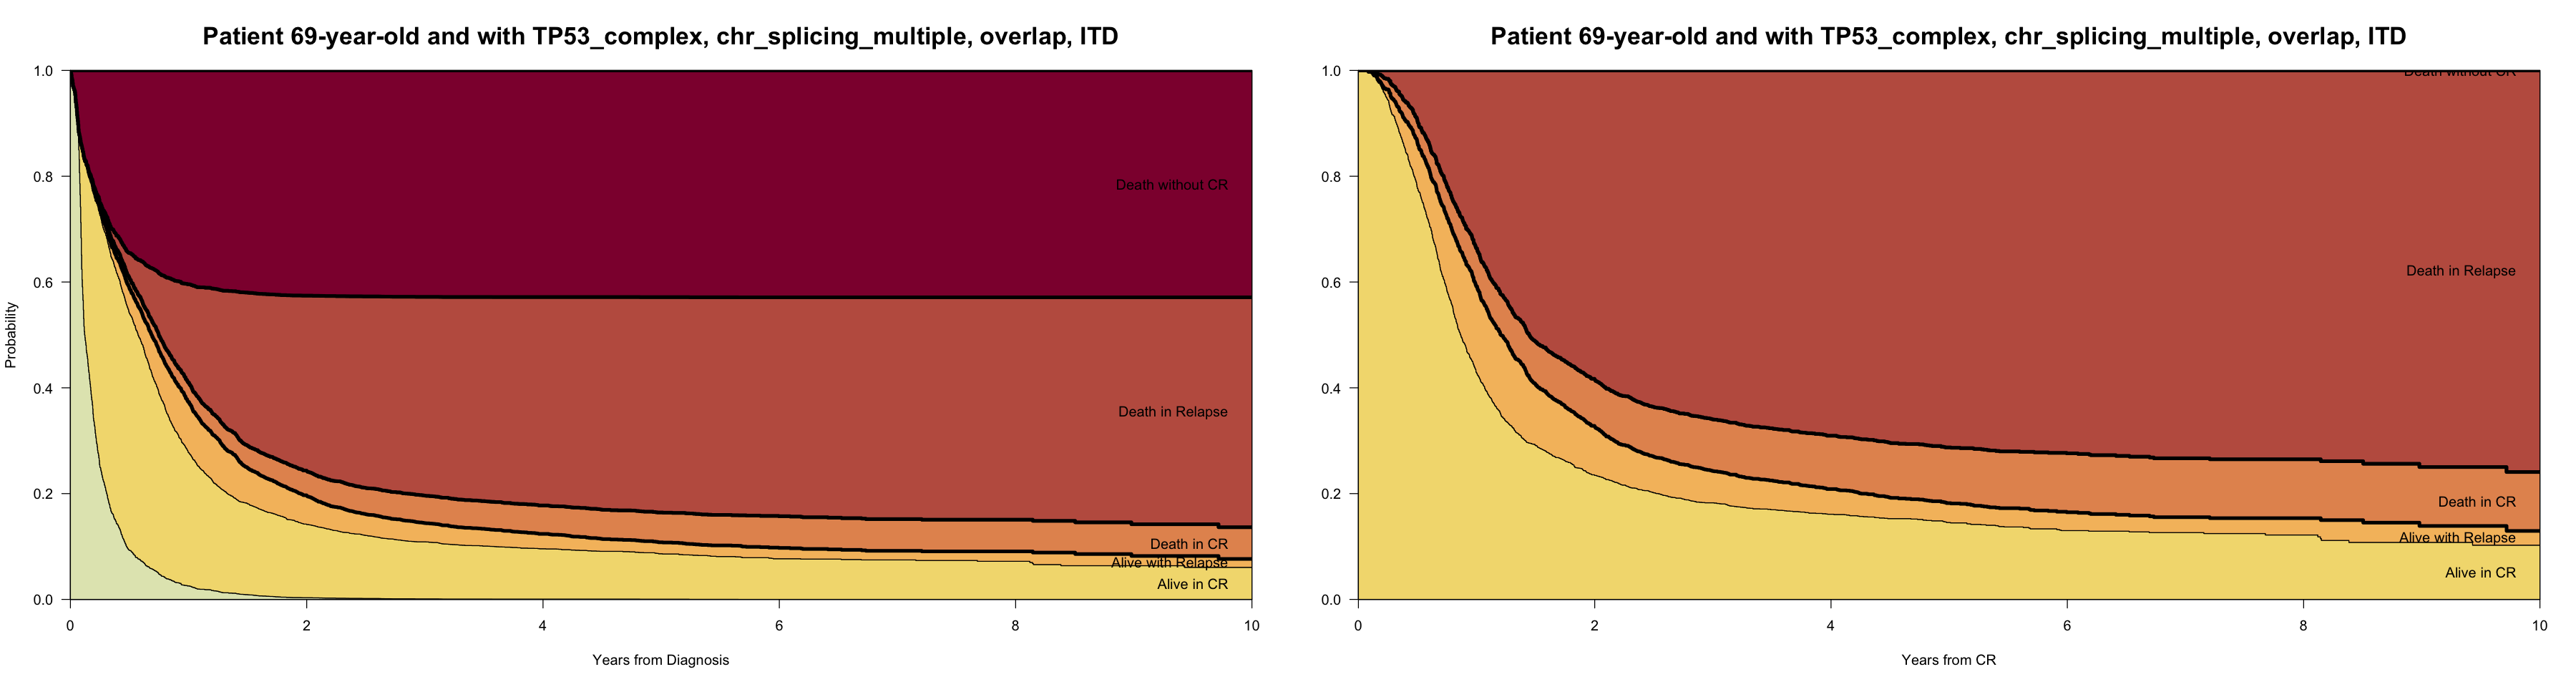

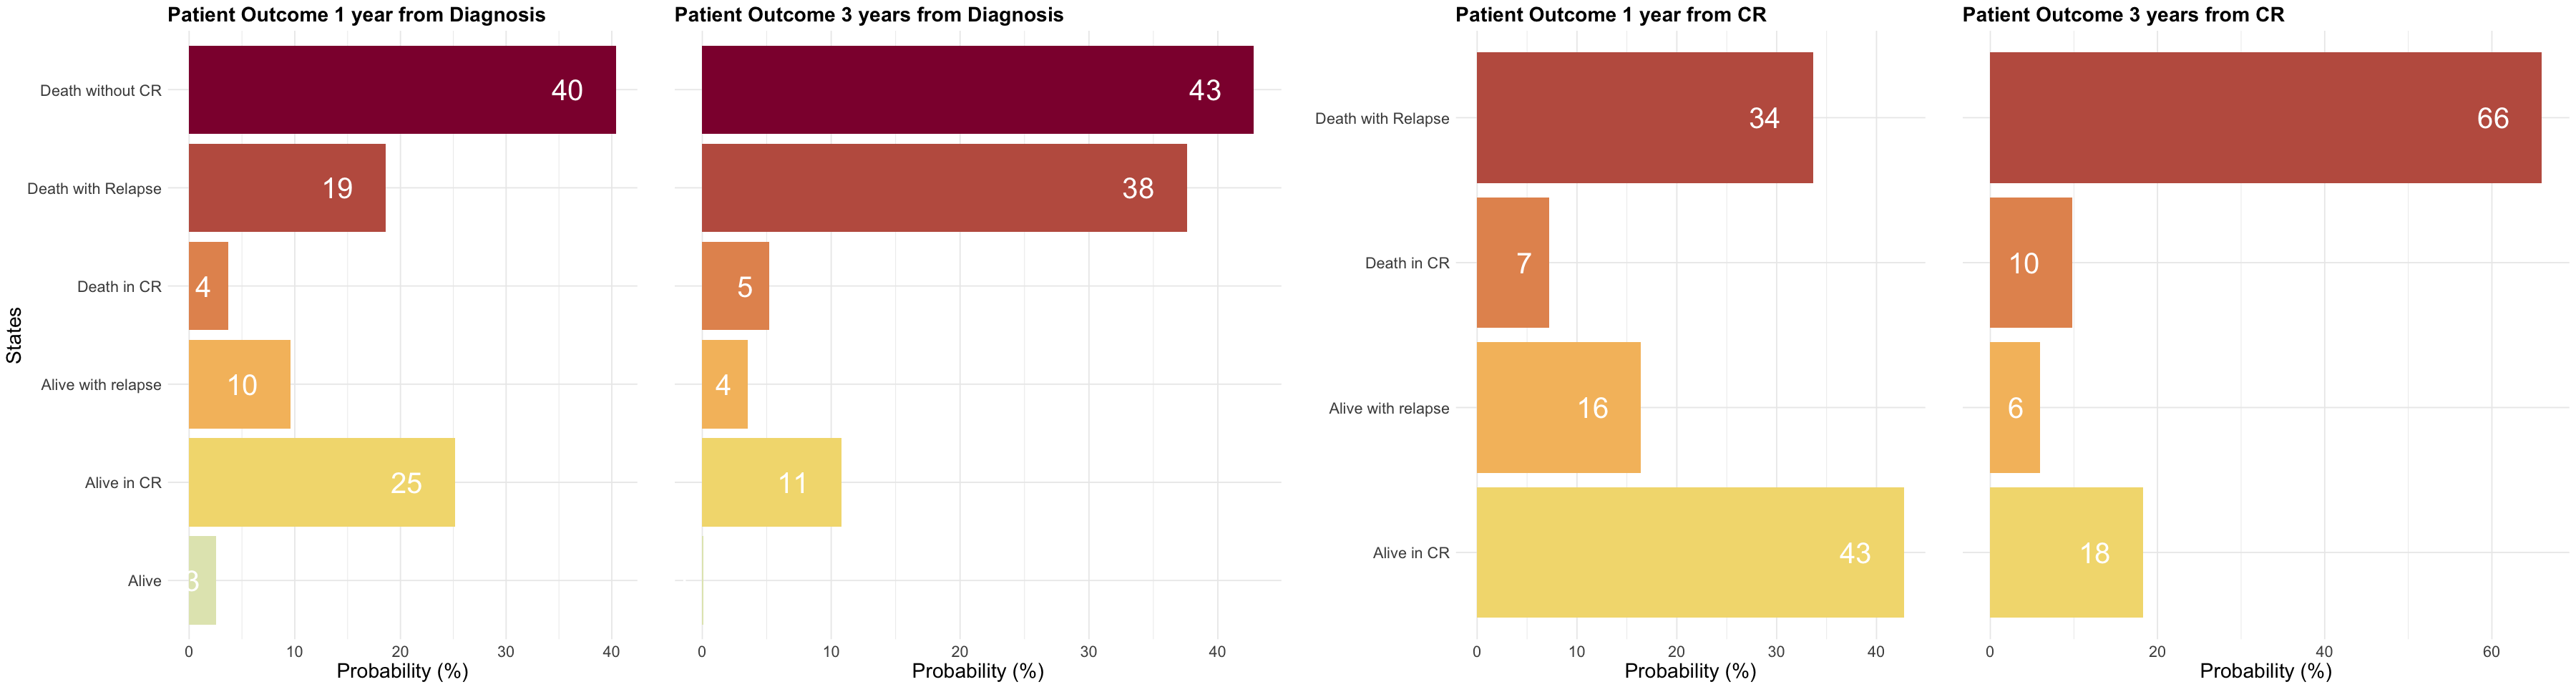

In [137]:
user_data_simplified <- classify_components(user_data)
covariates <- c(demo,clin,comp,"ITD","NEW_favorable","NEW_intermediate","NEW_adverse")
characteristics <- rownames(user_data_simplified[c(comp,"ITD","age"),,F][which(user_data_simplified[c(comp,"ITD","age"),"value"]>0),,F])
set_notebook_plot_size(30,8)
par(mfrow=c(1,2))


tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
tmp_data[nrow(tmp_data),covariates] <- as.numeric(user_data_simplified[covariates,])
patA <- tmp_data[rep(nrow(tmp_data),each=5),covariates]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data

patA <- expand.covs(patA, covariates, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

title_str1<- ifelse("age" %in% characteristics,paste("Patient ","-year-old and with",sep=as.character(user_data_simplified["age","value"])),"Patient with")
title_str2 <- toString(str_remove(characteristics[characteristics %in% c(comp,"ITD")],"full_component_"))
title_str <- paste(title_str1 , title_str2)

for (i in 1:2){
    plot(ptA,from=i, ord = c(1,2,3,4,5,6), main = title_str,cex.main=1.7,
    las = 1, xlab = ifelse(i==1,"Years from Diagnosis","Years from CR"), xlim = c(0, 10),
    type = "filled",ylab=ifelse(i==1,"Probability",""), col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}

ptrans1 <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA[[1]][ptA[[1]]$time>=1 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_1 <- ggplot(ptrans1,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+
  theme_minimal() + theme(axis.text=element_text(size=13),axis.title=element_text(size=17),plot.title=element_text(size=17,face="bold")) + ggtitle ("Patient Outcome 1 year from Diagnosis")

ptrans3 <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA[[1]][ptA[[1]]$time>=3 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_3 <-ggplot(ptrans3,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=13),axis.title=element_text(size=17),plot.title=element_text(size=17,face="bold"))+ ggtitle ("Patient Outcome 3 years from Diagnosis")


ptrans1_CR <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA[[2]][ptA[[2]]$time>=1 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_1 <- ggplot(ptrans1_CR,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+
  theme_minimal() + theme(axis.text=element_text(size=13),axis.title=element_text(size=17),plot.title=element_text(size=17,face="bold")) + ggtitle ("Patient Outcome 1 year from CR")

ptrans3_CR <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA[[2]][ptA[[2]]$time>=3 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_3 <-ggplot(ptrans3_CR,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=13),axis.title=element_text(size=17),plot.title=element_text(size=17,face="bold"))+ ggtitle ("Patient Outcome 3 years from CR")



grid.arrange(diagnosis_1,diagnosis_3,CR_1,CR_3,nrow=1)

# 2) Covariate Effects 

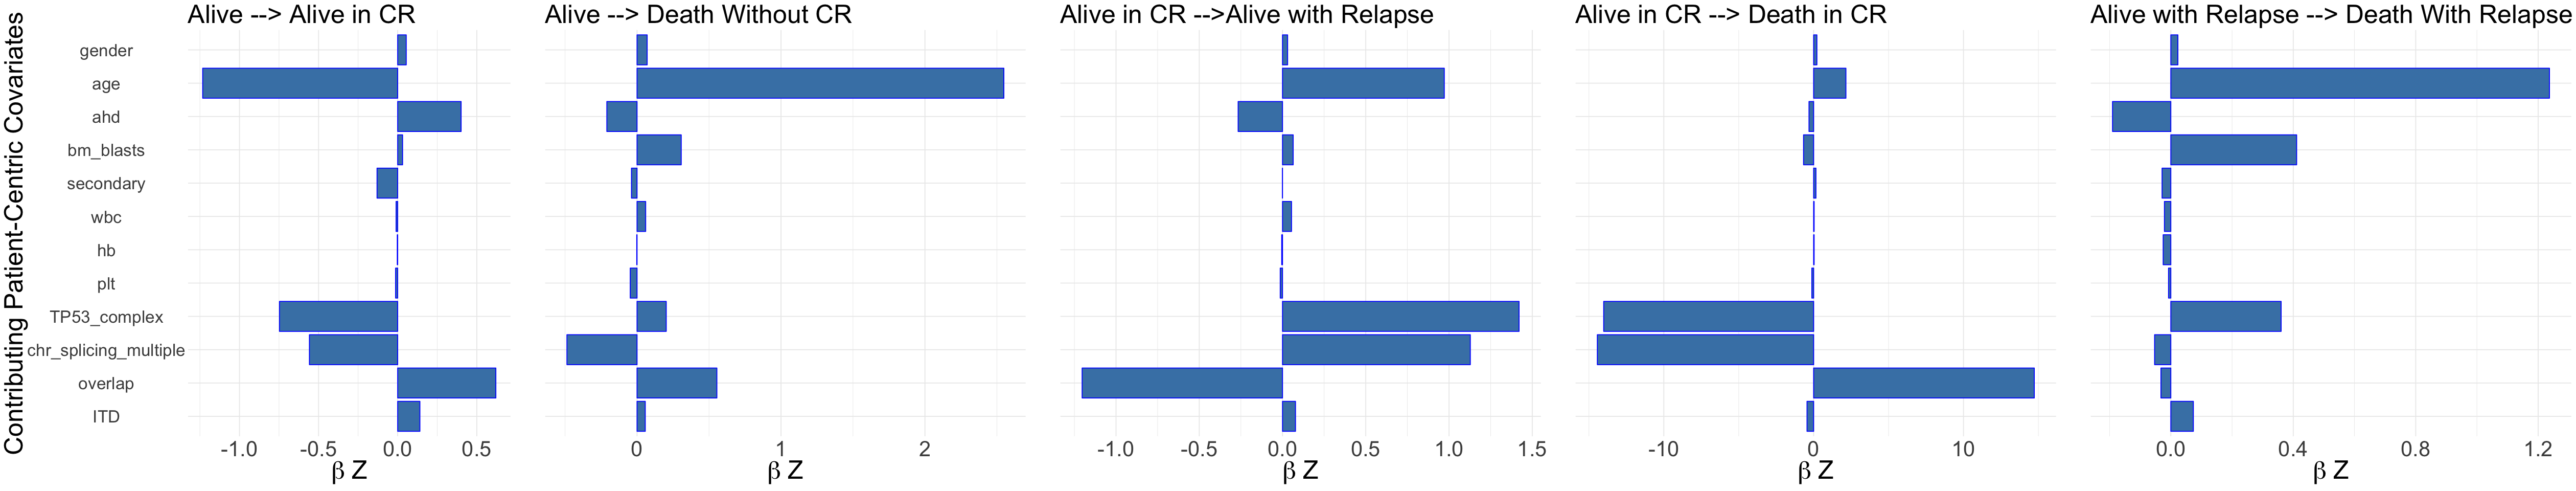

In [138]:
coef_data <- data.frame(summary(cfull)$coefficients)
set_notebook_plot_size(42,8)
p <- list()
count <- 1
for (trans in c(".1",".2",".3",".4",".5")){
    l <- coef_data[endsWith(rownames(coef_data),trans),]
    rownames(l) <- gsub('.{0,2}$', '', rownames(l))

    k <- merge(l,user_data_simplified,by=0)
    k["BetaZ"] <- k$coef * k$value
    k <- k %>%slice(match(covariates, Row.names))
    k <- k[(k$BetaZ!=0 & !is.na(k$BetaZ)),]
    k$Row.names <- str_remove(k$Row.names,"full_component_")
#     k <- k[order(k["BetaZ"],decreasing=T),]
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    xlab <- ifelse(trans==".1","Contributing Patient-Centric Covariates","")
    p[[trans]] <- ggplot(data = k,aes(x = factor(Row.names,level=rev(Row.names)),y= BetaZ)) + geom_bar(stat="identity",colour="blue",fill="steelblue") + coord_flip() + xlab(xlab) + ylab(expression(beta ~ Z)) + ggtitle(title) +
    theme_minimal() + theme(axis.title=element_text(size=30),axis.text.y=element_blank(),plot.title=element_text(size=30),axis.text.x=element_text(size=25)) 
    
    if(trans==".1"){
        p[[trans]] <- p[[trans]] + theme(axis.text.y=element_text(size=20))
    }
    #+ ifelse(trans==".1",theme(axis.text.x=element_text(size=20)),theme(axis.text.y=element_blank(),axis.ticks.y=element_blank()))
    #ifelse(trans==".1",theme(axis.text.x=element_blank()),theme(axis.text.x=element_text(size=20)))
    
}
do.call("grid.arrange",c(p,nrow=1))

In [140]:
nrow(df_nejm)

[1] 1176